### Generating names with recurrent neural networks (5 points)

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

In [2]:
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]
    

In [3]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


# Text processing

In [4]:
#all unique characters go here
tokens = set(''.join(names))

tokens = list(tokens)
print ('n_tokens = ',len(tokens))


n_tokens =  55


In [5]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

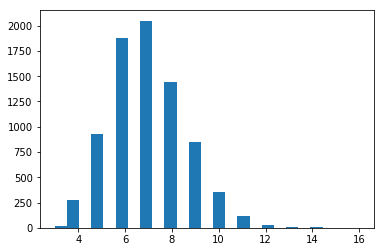

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,names)),bins=25);



In [7]:
# truncate names longer than MAX_LEN characters. 
MAX_LEN = 20

#you will likely need to change this for any dataset different from "names"


### Cast everything from symbols into identifiers

In [8]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [9]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')


# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [10]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [11]:

l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
l_emb = EmbeddingLayer(l_in, len(tokens), 8)

l_rnn = GRULayer(l_emb, 32, )

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

l_out = DenseLayer(l_rnn_flat, len(tokens), nonlinearity= lasagne.nonlinearities.softmax)




In [12]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print (weights)

[W, W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate, W_in_to_hidden_update, W_hid_to_hidden_update, b_hidden_update, W, b]


In [13]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [14]:

predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()


loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat,correct_answers_flat).mean()

updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [15]:

#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)


# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [16]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0],input_sequence.shape[1],len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)


In [17]:

def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets))


# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [18]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [19]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):

    print( "Generated names")
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))



Training ...
Generated names
----
  WVKbcnjvNUBUEqbdprqe;  xyWYrWPEnWkDgkXkBkns;  AturXAejoUpngkYv-syk;  zFIRhRtMspCKAIW'edko;  h hAjtlUgZmcoAfTabnf;  fcyAJNu rhsEuSXNeCZu;  sZPDqj-YKvzB SIJPnZu;  zqOCgpEEVKsNuBcAtlOU;  qKFCBOXAMIejnMWNjC'G;  YOQJWQIaaASgAWKnaGZM 
----
Epoch 0 average loss = 1.4351116937664703
Generated names
----
  tZvl   l   r        ;  YN               a  ;  Yav                 ;  Qr etti             ;  tansne   n          ;  HqgeJ e  a          ;  Dvf                 ;  Co  i               ;  vnr  i              ;  yn                   
----
Epoch 1 average loss = 1.0819479604675708
Generated names
----
  snyihnnea           ;  f                   ;  vkghsE              ;  uSoet               ;  AwanYf       n      ;  atyrdi              ;   Mtroe              ;  E                   ;  Luhai  n            ;  aIl                  
----
Epoch 2 average loss = 0.9884194082404353
Generated names
----
  Nsila               ;  Latriirgre          ;  Wiicua              ;

Epoch 27 average loss = 0.7837820417370307
Generated names
----
  Dotnia              ;  Reshare             ;  Consya              ;  Cariaze             ;  Nailia              ;  Anbrik              ;  Jannand             ;  Yobehann            ;  Jeowel              ;  Rond                 
----
Epoch 28 average loss = 0.7760891966437923
Generated names
----
  Wergne              ;  Fricky              ;  Eliprell            ;  Garter              ;  Amreze              ;  Raxfynd             ;  Dottolyn            ;  Malle               ;  Barthena            ;  Shath                
----
Epoch 29 average loss = 0.772810320658366
Generated names
----
  Leba                ;  Theundan            ;  Resse               ;  Mautyn              ;  Lesalin             ;  Kariet              ;  Heret               ;  Guika               ;  Karev               ;  Haberrie             
----
Epoch 30 average loss = 0.7743485208837871
Generated names
----
  Welzanne            ;  Mursti      

Epoch 55 average loss = 0.7447064091853415
Generated names
----
  Rodeie              ;  Givin               ;  Arnchellick         ;  Jabo                ;  Anthy               ;  Gabbiall            ;  Tmishil             ;  Scharie             ;  Kapamen             ;  Dari                 
----
Epoch 56 average loss = 0.7437706621698842
Generated names
----
  Lebmin              ;  Maith               ;  Havena              ;  Dele                ;  Eobe                ;  Danishe             ;  Dulkyce             ;  Adalen              ;  Iilina              ;  Tanwonn              
----
Epoch 57 average loss = 0.7478814093055121
Generated names
----
  Meril               ;  Frandy              ;  Beandra             ;  Deerut              ;  Tam                 ;  Kerthenu            ;  Kirtreren           ;  Wisley              ;  Giggona             ;  Meld                 
----
Epoch 58 average loss = 0.7473930333901436
Generated names
----
  Harde               ;  Brisy      

Epoch 83 average loss = 0.7316399485950448
Generated names
----
  Shesend             ;  Wil                 ;  Amery               ;  Jokifale            ;  Rocigne             ;  Woley               ;  Blice               ;  Fres                ;  Elene               ;  Watebai              
----
Epoch 84 average loss = 0.7301165988886936
Generated names
----
  Olelina             ;  Otrel               ;  Doodias             ;  Erison              ;  Aryna               ;  Twarore             ;  Mathius             ;  Wristanin           ;  Fonton              ;  Cheriel              
----
Epoch 85 average loss = 0.7328350705165617
Generated names
----
  Clis                ;  Peir                ;  Leminsande          ;  Karila              ;  Bett                ;  Gerard              ;  Bestar              ;  Dura                ;  Rebitita            ;  Tusta                
----
Epoch 86 average loss = 0.7326930361482223
Generated names
----
  Ellenchan           ;  Terris     

In [20]:
generate_sample(n_snippets=100)

----
  Jaquelay            ;  Elysed              ;  Maghabelita         ;  Jibil               ;  Ery-Krikdanka       ;  Lorena              ;  Agna                ;  Myrah               ;  Azti                ;  Egen-Paul           ;  Jackeanne           ;  Halse               ;  Thory               ;  Pheley              ;  Letne               ;  Pat                 ;  Layne               ;  Arorie              ;  Wigneve             ;  Cladd               ;  Dail                ;  Ropilland           ;  Heldil              ;  Dorenta             ;  Rox                 ;  Ambor               ;  Anna-Mallo          ;  Varalyn             ;  Cigfra              ;  Jelmi               ;  Krittie             ;  Beni                ;  Emeth               ;  Ment                ;  Eworia              ;  Jeria               ;  Gibbi               ;  Grandie             ;  Marikanne           ;  Bern                ;  Sumey               ;  Wyb                 ;  Rounetta            ;  Sama

In [23]:
generate_sample(seed_phrase=" Lat",n_snippets=100)

----
  Late                   ;  Latie                  ;  Latulicue              ;  Late                   ;  Lathris                ;  Lat                    ;  Latis                  ;  Lathie                 ;  Latas                  ;  Latie                  ;  Latiantie              ;  Latela                 ;  Latcie                 ;  Latio                  ;  Lathriid               ;  Lathelina              ;  Lathellan              ;  Latrest                ;  Latth                  ;  Latos                  ;  Lathee                 ;  Lathrep                ;  Laty                   ;  Latgelle               ;  Laterine               ;  Lathundie              ;  Lathtele               ;  Lateine                ;  Lathelle               ;  Lathely                ;  Lathly                 ;  Lat                    ;  Latheline              ;  Latrie                 ;  Latheben               ;  Lat                    ;  Latrels                ;  Latie                  ;  Latee

In [ ]:
generate_sample(seed_phrase=<whatever you please>,n_snippets=10,t=1.0)

### Bonus: try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__